In [74]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [23]:
# set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
# load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=3)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [77]:
# load data
data = pd.read_excel('Dataset_BC_raw.xlsx')
sentences = data['text'].values
labels = data['label'].values

In [78]:
# tokenize & encode data
input_ids = [tokenizer.encode(sent, add_special_tokens = True) for sent in sentences]

In [79]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# set maximum sequence length
max_len = 128

# pad and truncate sequences
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post")

In [80]:
# creating attention masks
attention_masks = []
for seq in input_ids:
    seq_mask = [int(token_id != tokenizer.pad_token_id) for token_id in seq]
    attention_masks.append(seq_mask)

In [81]:
# split data into train and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

In [32]:
#Adjusting tensor size for labels in Train
one_hot_labels_train = []
for label in train_labels:
    if label == "positive":
        one_hot_labels_train.append([1, 0, 0])
    elif label == "negative":
        one_hot_labels_train.append([0, 1, 0])
    else:
        one_hot_labels_train.append([0, 0, 1])

#Adjusting tensor size in Test
one_hot_labels_test = []
for label in test_labels:
    if label == "positive":
        one_hot_labels_test.append([1, 0, 0])
    elif label == "negative":
        one_hot_labels_test.append([0, 1, 0])
    else:
        one_hot_labels_test.append([0, 0, 1])

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(one_hot_labels_train, dtype=torch.long)
test_labels = torch.tensor(one_hot_labels_test, dtype=torch.long)

train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

In [82]:
#Converting labels into numbers
label_map = {"positive": 1, "negative": 0, "neutral": 0.5}
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

<ipython-input-82-505975a54473>:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_labels = torch.tensor(train_labels, dtype=torch.long)
<ipython-input-82-505975a54473>:12: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  test_labels = torch.tensor(test_labels, dtype=torch.long)


In [83]:
# create DataLoader objects
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# set optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

<ipython-input-83-fef89d54c0bc>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
<ipython-input-83-fef89d54c0bc>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [84]:
# fine-tune model
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        print(step, b_input_ids.shape)
        print(step, b_input_mask.shape)
        print(step, b_labels.shape)


0 torch.Size([32, 128])
0 torch.Size([32, 128])
0 torch.Size([32])
1 torch.Size([32, 128])
1 torch.Size([32, 128])
1 torch.Size([32])
2 torch.Size([32, 128])
2 torch.Size([32, 128])
2 torch.Size([32])
3 torch.Size([32, 128])
3 torch.Size([32, 128])
3 torch.Size([32])
4 torch.Size([32, 128])
4 torch.Size([32, 128])
4 torch.Size([32])
5 torch.Size([32, 128])
5 torch.Size([32, 128])
5 torch.Size([32])
6 torch.Size([14, 128])
6 torch.Size([14, 128])
6 torch.Size([14])
0 torch.Size([32, 128])
0 torch.Size([32, 128])
0 torch.Size([32])
1 torch.Size([32, 128])
1 torch.Size([32, 128])
1 torch.Size([32])
2 torch.Size([32, 128])
2 torch.Size([32, 128])
2 torch.Size([32])
3 torch.Size([32, 128])
3 torch.Size([32, 128])
3 torch.Size([32])
4 torch.Size([32, 128])
4 torch.Size([32, 128])
4 torch.Size([32])
5 torch.Size([32, 128])
5 torch.Size([32, 128])
5 torch.Size([32])
6 torch.Size([14, 128])
6 torch.Size([14, 128])
6 torch.Size([14])
0 torch.Size([32, 128])
0 torch.Size([32, 128])
0 torch.Size([

In [85]:
# fine-tune model
epochs = 4
loss_values = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
            
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        total_loss += outputs[0].item()
        outputs[0].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print('Average training loss: ', avg_train_loss)

    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

Average training loss:  1.44101083278656
Average training loss:  0.7759873952184405
Average training loss:  0.5765689611434937
Average training loss:  0.4742311196667807


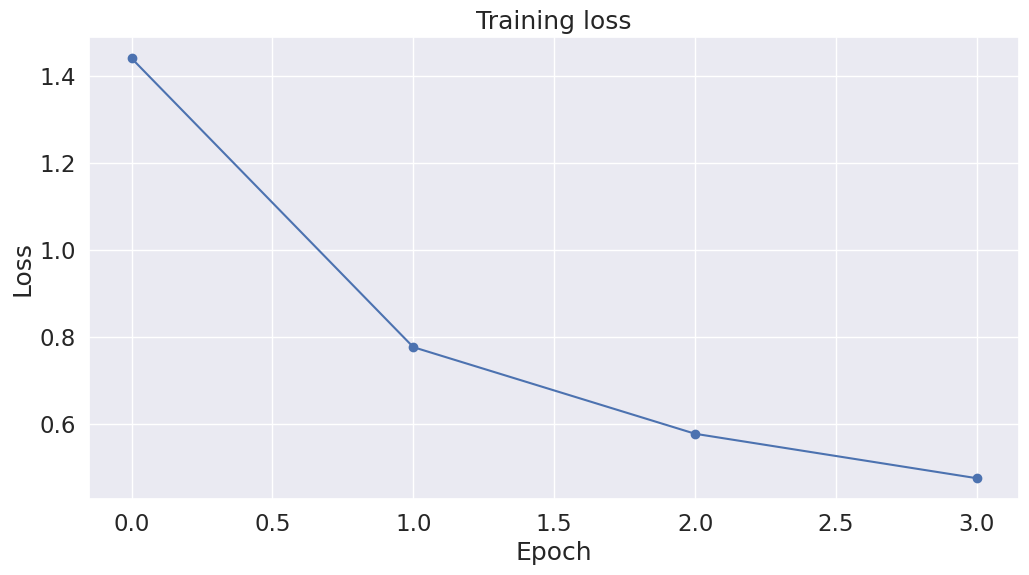

In [86]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [87]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')